In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2024-11-23 21:40:18.393053: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 21:40:18.402105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732426818.412986  232284 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732426818.416130  232284 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 21:40:18.428038: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 6

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

2024-11-23 21:40:20.408304: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,136 (4.44 KB)

 Trainable params: 1,136 (4.44 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/12 ━━━━━━━━━━━━━━━━━━━━ 5s 504ms/step - accuracy: 0.1875 - loss: 1.8879
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1569 - loss: 1.9680 - val_accuracy: 0.1663 - val_loss: 1.8515
Epoch 2/1000
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1250 - loss: 1.8950
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1567 - loss: 1.8923 - val_accuracy: 0.1703 - val_loss: 1.7964
Epoch 3/1000
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1250 - loss: 1.8679
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1655 - loss: 1.8372 - val_accuracy: 0.2055 - val_loss: 1.7625
Epoch 4/1000
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2188 - loss: 1.7665
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.ker

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9054 - loss: 0.5907


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[2.2638819e-01 2.9292839e-02 2.8642695e-03 6.9259346e-02 5.0457491e-04
 6.7169082e-01]
5


# Confusion matrix

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


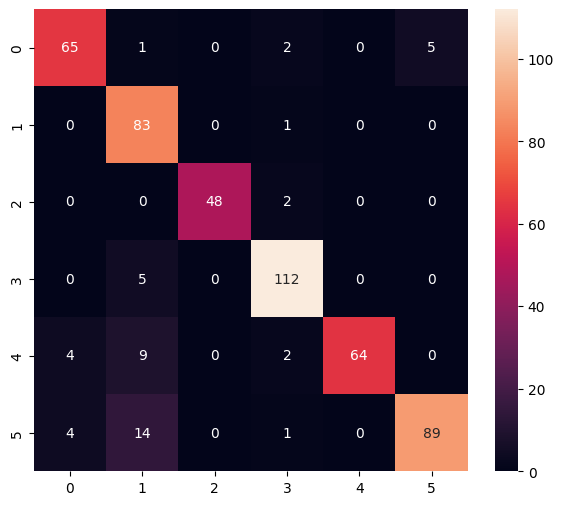

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        73
           1       0.74      0.99      0.85        84
           2       1.00      0.96      0.98        50
           3       0.93      0.96      0.95       117
           4       1.00      0.81      0.90        79
           5       0.95      0.82      0.88       108

    accuracy                           0.90       511
   macro avg       0.92      0.90      0.91       511
weighted avg       0.92      0.90      0.90       511



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpa6c_xar_/assets


INFO:tensorflow:Assets written to: /tmp/tmpa6c_xar_/assets


Saved artifact at '/tmp/tmpa6c_xar_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134550801659472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134550801660624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134550708614160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134550708602064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134550708602256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134550708613776: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732426922.820996  232284 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732426922.821033  232284 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-23 21:42:02.821449: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpa6c_xar_
2024-11-23 21:42:02.821775: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-23 21:42:02.821782: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpa6c_xar_
I0000 00:00:1732426922.824319  232284 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2024-11-23 21:42:02.824728: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-23 21:42:02.840804: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpa6c_xar_
2024-11-23 21:42:02.844744: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 

6624

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 127 μs, sys: 25 μs, total: 152 μs
Wall time: 130 μs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.2638804e-01 2.9292854e-02 2.8642684e-03 6.9259353e-02 5.0457497e-04
 6.7169088e-01]
5
